## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb


# Using unpreprocessed data

## Data loading

In [5]:
train_data = pd.read_csv('../data/train.csv')


### Data split

In [7]:
# Check for missing values
print(train_data.isnull().sum())

# Fill missing values or drop them
train_data.fillna(train_data.median(), inplace=True)

# Encoding categorical variables if necessary
# Here, I'm assuming there are categorical variables. Adjust as per your dataset.
train_data = pd.get_dummies(train_data)

# Ensure train and test data have the same columns
# train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Separate features and target
X = train_data.drop('smoking', axis=1)
y = train_data['smoking']


id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Model - XGBRegressor

In [10]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f'XGBoost RMSE: {xgb_rmse}')


XGBoost RMSE: 0.38725767399198574


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize the model
xgb = XGBRegressor(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=2, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb_best


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

## NN - ROC - 0.80623

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

# Define the model architecture
model = Sequential()
model.add(Dense(22, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3982/3982 - 5s - 1ms/step - AUC: 0.5791 - loss: 25.4712 - val_AUC: 0.6353 - val_loss: 5.3111
Epoch 2/100
3982/3982 - 4s - 931us/step - AUC: 0.6295 - loss: 5.8477 - val_AUC: 0.7828 - val_loss: 1.4889
Epoch 3/100
3982/3982 - 4s - 909us/step - AUC: 0.6478 - loss: 4.3028 - val_AUC: 0.5896 - val_loss: 6.2866
Epoch 4/100
3982/3982 - 4s - 920us/step - AUC: 0.6593 - loss: 2.8470 - val_AUC: 0.6928 - val_loss: 2.1983
Epoch 5/100
3982/3982 - 4s - 902us/step - AUC: 0.6697 - loss: 1.7914 - val_AUC: 0.6107 - val_loss: 2.8768
Epoch 6/100
3982/3982 - 4s - 906us/step - AUC: 0.6945 - loss: 1.1439 - val_AUC: 0.7955 - val_loss: 0.5918
Epoch 7/100
3982/3982 - 4s - 909us/step - AUC: 0.6996 - loss: 0.6693 - val_AUC: 0.5453 - val_loss: 0.6778
Epoch 8/100
3982/3982 - 4s - 908us/step - AUC: 0.5928 - loss: 0.6743 - val_AUC: 0.5315 - val_loss: 0.6778
Epoch 9/100
3982/3982 - 4s - 891us/step - AUC: 0.5335 - loss: 0.6777 - val_AUC: 0.5187 - val_loss: 0.6817
Epoch 10/100
3982/3982 - 4s - 907us/step - AUC: 0.5130 - lo

In [17]:
X_test = pd.read_csv('../data/test.csv')

In [19]:
X_test

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,265422,40,165,60,78.0,0.8,0.9,1,1,112,...,82,59,149,16.4,1,1.1,24,31,28,0
106167,265423,40,170,85,95.0,1.2,1.2,1,1,130,...,186,44,100,16.0,2,1.0,25,31,38,0
106168,265424,35,170,85,89.0,1.2,1.2,1,1,131,...,76,53,142,15.9,1,0.8,33,32,24,1
106169,265425,40,160,60,67.0,0.7,0.8,1,1,120,...,81,55,103,13.9,1,0.6,42,36,32,0


In [20]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step


## NN - ROC - 0.83979

In [22]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3982/3982 - 8s - 2ms/step - AUC: 0.6268 - loss: 0.6707 - val_AUC: 0.8002 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 2/100
3982/3982 - 6s - 2ms/step - AUC: 0.7553 - loss: 0.5759 - val_AUC: 0.8159 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 3/100
3982/3982 - 7s - 2ms/step - AUC: 0.7785 - loss: 0.5531 - val_AUC: 0.7961 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 4/100
3982/3982 - 6s - 2ms/step - AUC: 0.7860 - loss: 0.5439 - val_AUC: 0.8061 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 5/100
3982/3982 - 6s - 2ms/step - AUC: 0.7917 - loss: 0.5383 - val_AUC: 0.7962 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 6/100
3982/3982 - 6s - 2ms/step - AUC: 0.7948 - loss: 0.5338 - val_AUC: 0.8258 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 7/100
3982/3982 - 6s - 1ms/step - AUC: 0.7976 - loss: 0.5302 - val_AUC: 0.8262 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 8/100
3982/3982 - 6s - 2ms/step - AUC: 0.8010 - loss: 0.5263 - val_AUC: 0.8216 - val_loss: 0.5338 - learning_r

In [23]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step


In [31]:
history.history.keys()

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss', 'learning_rate'])

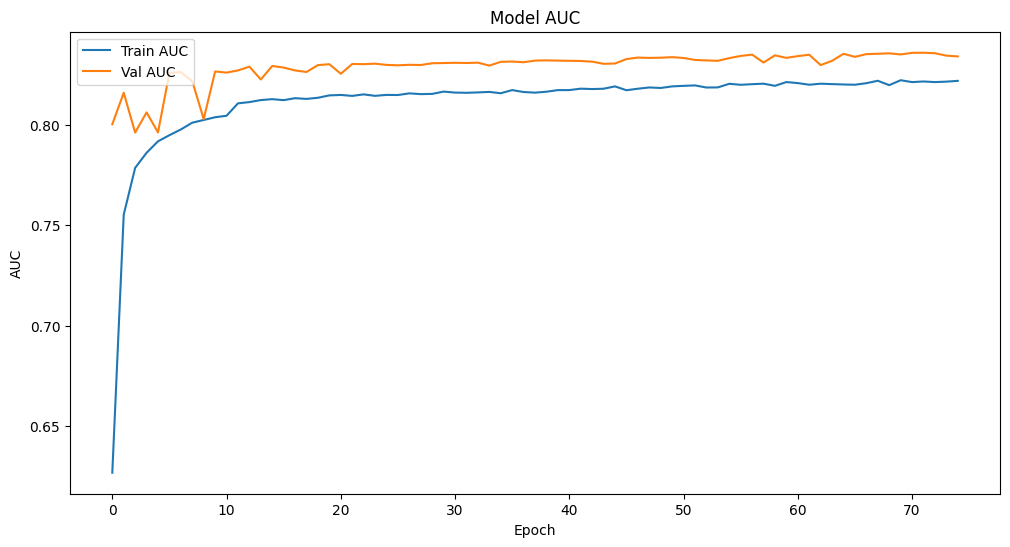

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation AUC values
plt.figure(figsize=(12, 6))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


## NN - ROC - ??

In [ ]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

## XGBoost - ROC - 

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7803905563229938
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     17783
           1       0.73      0.80      0.76     14069

    accuracy                           0.78     31852
   macro avg       0.78      0.78      0.78     31852
weighted avg       0.79      0.78      0.78     31852



# Using preprocessed data

## Data loading

### Reading the preprocessed csv

In [34]:
train_data = pd.read_csv('../data/train_data_preprocessed.csv')

In [35]:
# Check for missing values
print(train_data.isnull().sum())

# Fill missing values or drop them
train_data.fillna(train_data.median(), inplace=True)

# Encoding categorical variables if necessary
# Here, I'm assuming there are categorical variables. Adjust as per your dataset.
train_data = pd.get_dummies(train_data)

# Ensure train and test data have the same columns
# train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Separate features and target
X = train_data.drop('smoking', axis=1)
y = train_data['smoking']

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
systolic               0
relaxation             0
fasting blood sugar    0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
BMI                    0
hearing                0
eyesight               0
AST/ALT_ratio          0
smoking                0
dtype: int64


### Splitting it

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training - NN - ROC - 0.85871

In [38]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 9s - 2ms/step - AUC: 0.8098 - loss: 0.5155 - val_AUC: 0.8440 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 7s - 1ms/step - AUC: 0.8303 - loss: 0.4894 - val_AUC: 0.8452 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 7s - 1ms/step - AUC: 0.8330 - loss: 0.4868 - val_AUC: 0.8468 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 7s - 1ms/step - AUC: 0.8345 - loss: 0.4847 - val_AUC: 0.8481 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 7s - 1ms/step - AUC: 0.8347 - loss: 0.4839 - val_AUC: 0.8475 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 7s - 1ms/step - AUC: 0.8339 - loss: 0.4851 - val_AUC: 0.8483 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 7s - 1ms/step - AUC: 0.8355 - loss: 0.4837 - val_AUC: 0.8483 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 7s - 1ms/step - AUC: 0.8358 - loss: 0.4833 - val_AUC: 0.8484 - val_loss: 0.4687 - learning_r

In [43]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step


## Training - NN - ROC - 0.85812

In [44]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')

Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 10s - 2ms/step - AUC: 0.8141 - loss: 0.5094 - val_AUC: 0.8403 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 7s - 1ms/step - AUC: 0.8315 - loss: 0.4887 - val_AUC: 0.8471 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 7s - 1ms/step - AUC: 0.8330 - loss: 0.4869 - val_AUC: 0.8463 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 7s - 1ms/step - AUC: 0.8336 - loss: 0.4859 - val_AUC: 0.8474 - val_loss: 0.4688 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 7s - 1ms/step - AUC: 0.8343 - loss: 0.4850 - val_AUC: 0.8479 - val_loss: 0.4710 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 7s - 1ms/step - AUC: 0.8348 - loss: 0.4837 - val_AUC: 0.8475 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 7s - 1ms/step - AUC: 0.8354 - loss: 0.4838 - val_AUC: 0.8484 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 8s - 2ms/step - AUC: 0.8357 - loss: 0.4833 - val_AUC: 0.8471 - val_loss: 0.4698 - learning_

In [97]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step


ValueError: array length 1698736 does not match index length 106171

### plots

In [101]:
model

<Sequential name=sequential_10, built=True>

[64, 32, 16, 1]


In [81]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

In [ ]:
# Get the list of layers
layers = model.layers

# Extract the number of neurons for each layer that has neurons
layer_neurons = []
layers_found = []
for layer in layers:
    if hasattr(layer, 'units'):
        layers_found.append(layer.units)

print(layers_found)

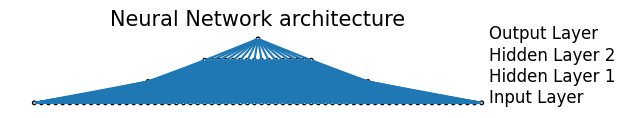

In [107]:
network = DrawNN(layers_found)
network.draw()

In [73]:
network = DrawNN( [2,8,8,1] )
network.draw()

NameError: name 'xrange' is not defined

## NN - MULTITHREADING - ROC - ???